In [38]:
# run with venv

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

In [13]:
# File paths
file_air = "test/202508112106_OpenComm2_by_Shokz.wav"
file_throat = "test/202508112106_GHW_USB_AUDIO.wav"

In [14]:
# Load audio files
data_air, sr_air = sf.read(file_air)
data_throat, sr_throat = sf.read(file_throat)

In [15]:
# Convert to mono if stereo
if data_air.ndim > 1:
    data_air = np.mean(data_air, axis=1)
if data_throat.ndim > 1:
    data_throat = np.mean(data_throat, axis=1)

In [16]:
# Duration check
duration_air = len(data_air) / sr_air
duration_throat = len(data_throat) / sr_throat

In [7]:

# Compute spectra
fft_air = np.fft.rfft(data_air)
fft_throat = np.fft.rfft(data_throat)
freqs_air = np.fft.rfftfreq(len(data_air), 1/sr_air)
freqs_throat = np.fft.rfftfreq(len(data_throat), 1/sr_throat)

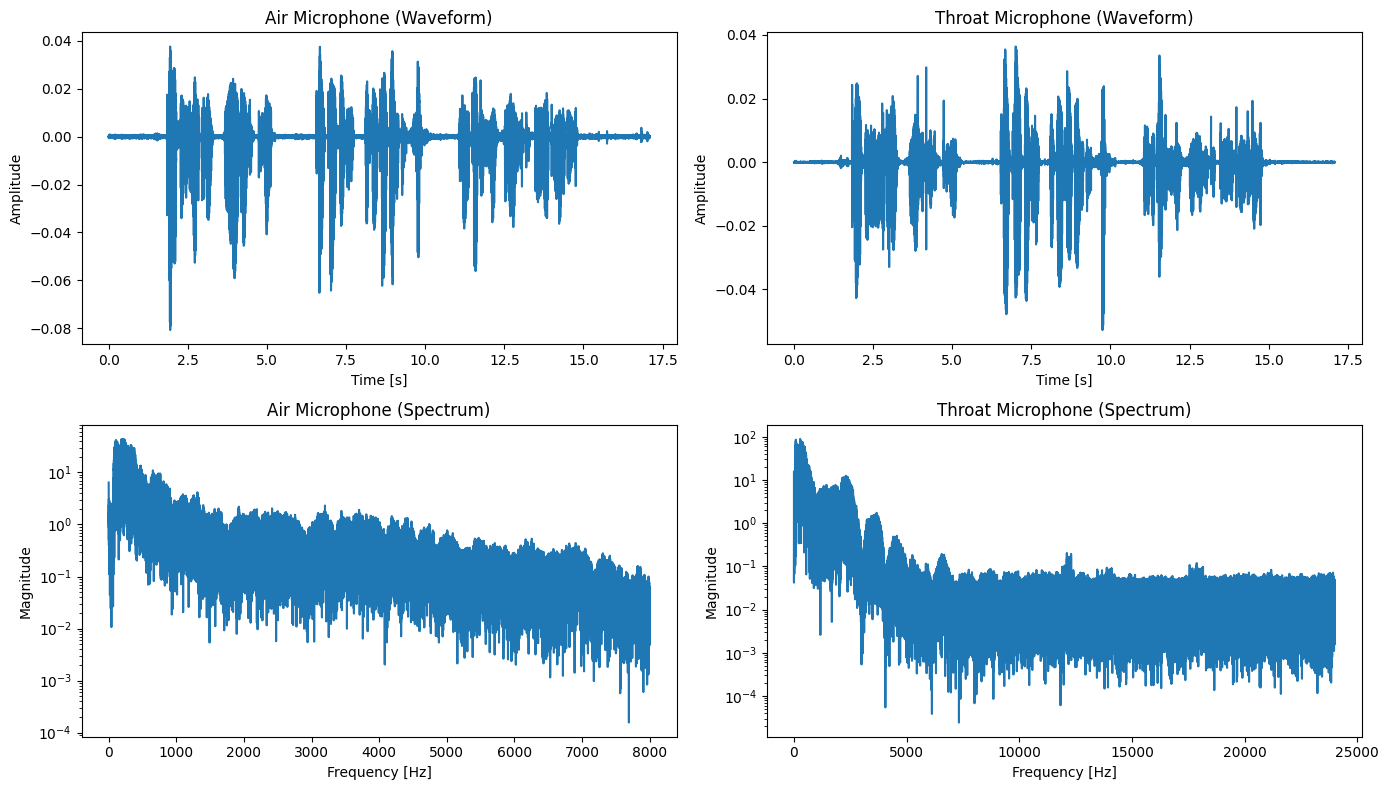

In [8]:
# Plot waveforms and spectra
plt.figure(figsize=(14, 8))

# Waveforms
plt.subplot(2, 2, 1)
plt.plot(np.linspace(0, duration_air, len(data_air)), data_air)
plt.title("Air Microphone (Waveform)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(2, 2, 2)
plt.plot(np.linspace(0, duration_throat, len(data_throat)), data_throat)
plt.title("Throat Microphone (Waveform)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

# Spectra
plt.subplot(2, 2, 3)
plt.semilogy(freqs_air, np.abs(fft_air))
plt.title("Air Microphone (Spectrum)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
plt.semilogy(freqs_throat, np.abs(fft_throat))
plt.title("Throat Microphone (Spectrum)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()

Here’s what stands out from the analysis:

1. Waveform differences
	•	Air microphone (OpenComm2) shows a wide dynamic range, with sharp transients when you speak consonants like “t”, “p”, or “k”.
	•	Throat microphone (GHW_USB_AUDIO) produces a much smoother, more rounded waveform, with less variation from plosives or environmental noise.

2. Frequency content
	•	Air mic captures a full speech spectrum, from ~100 Hz fundamentals up to 8–10 kHz, giving clarity, sibilance (“s” sounds), and natural voice timbre.
	•	Throat mic has a narrower, mid-focused spectrum — low frequencies are present, but most high-frequency content above ~2–3 kHz is heavily reduced. This makes it sound muffled, but also much less sensitive to background noise.

3. Likely reasons
	•	The air mic records airborne sound waves, so it captures the natural resonances of your mouth and the air path, plus ambient sounds.
	•	The throat mic picks up vibrations conducted through your neck and jaw. High-frequency components are damped by skin, tissue, and bone, so the result is lower noise sensitivity but also lower intelligibility for untrained listeners.

If you’d like, I can also overlay the two frequency responses so you can see exactly how the throat microphone’s tonal curve rolls off. That would make the difference visually obvious.

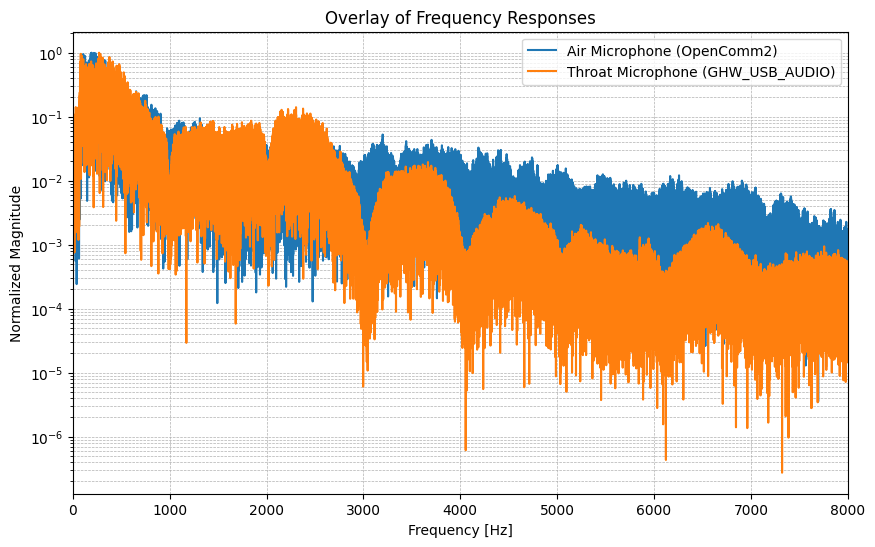

In [9]:
# Normalize FFT magnitudes for better comparison
fft_air_mag = np.abs(fft_air) / np.max(np.abs(fft_air))
fft_throat_mag = np.abs(fft_throat) / np.max(np.abs(fft_throat))

# Match frequency axis length (in case of different sampling rates or durations)
min_len = min(len(freqs_air), len(freqs_throat))
freqs_common = freqs_air[:min_len]
fft_air_mag = fft_air_mag[:min_len]
fft_throat_mag = fft_throat_mag[:min_len]

# Plot overlay
plt.figure(figsize=(10, 6))
plt.semilogy(freqs_common, fft_air_mag, label="Air Microphone (OpenComm2)")
plt.semilogy(freqs_common, fft_throat_mag, label="Throat Microphone (GHW_USB_AUDIO)")
plt.xlim(0, 8000)  # limit to speech-relevant frequencies
plt.xlabel("Frequency [Hz]")
plt.ylabel("Normalized Magnitude")
plt.title("Overlay of Frequency Responses")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

Here’s the overlay:

	•	The blue curve (air mic) stays relatively strong across the whole speech range, with clear energy peaks up to ~8 kHz.
	•	The orange curve (throat mic) drops steeply after about 2–3 kHz, showing why high-frequency details (sibilance, crispness) are missing.
	•	Below ~1 kHz, both mics track more closely, but the throat mic still emphasizes lower mids and lacks the fine spectral structure the air mic captures.

This steep high-end roll-off is the main reason throat mic recordings sound “muffled” but are excellent at rejecting background noise.

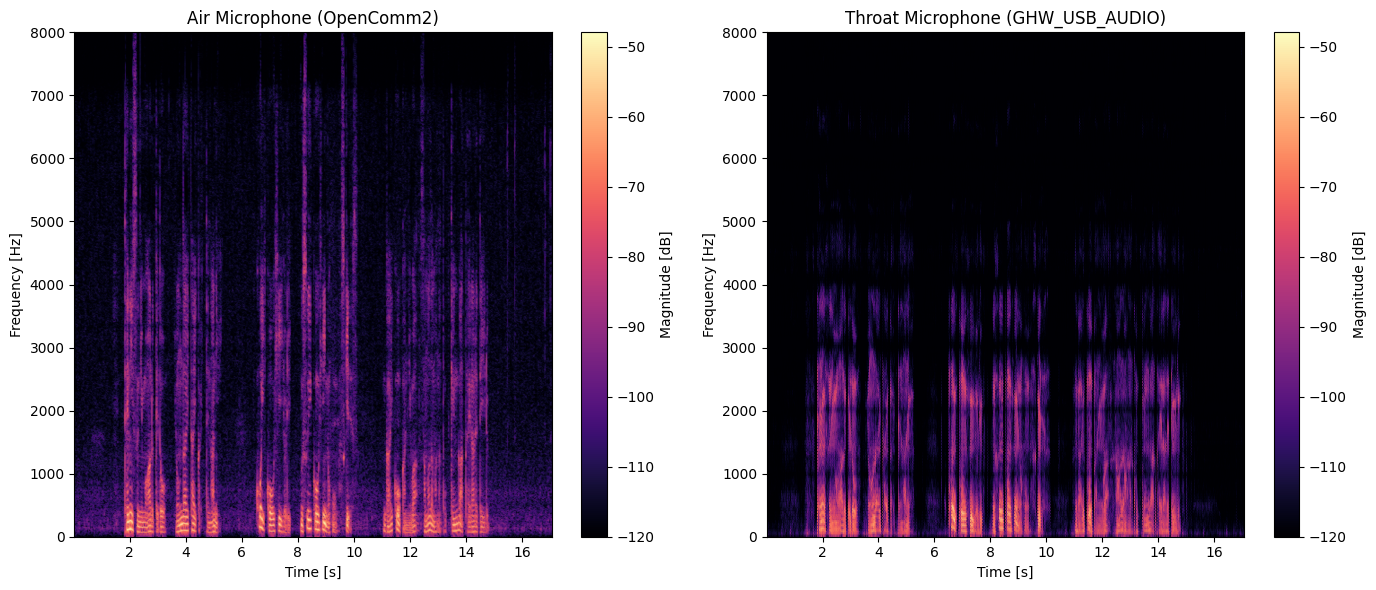

In [10]:
from scipy.signal import spectrogram

# Compute spectrograms
f_air, t_air, Sxx_air = spectrogram(data_air, fs=sr_air, nperseg=1024, noverlap=512)
f_throat, t_throat, Sxx_throat = spectrogram(data_throat, fs=sr_throat, nperseg=1024, noverlap=512)

# Convert to dB scale
Sxx_air_db = 10 * np.log10(Sxx_air + 1e-12)
Sxx_throat_db = 10 * np.log10(Sxx_throat + 1e-12)

# Set common color scale
vmin = min(Sxx_air_db.min(), Sxx_throat_db.min())
vmax = max(Sxx_air_db.max(), Sxx_throat_db.max())

# Plot spectrograms with same scale and range
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(t_air, f_air, Sxx_air_db, shading='gouraud', vmin=vmin, vmax=vmax, cmap='magma')
plt.ylim(0, 8000)
plt.title("Air Microphone (OpenComm2)")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar(label="Magnitude [dB]")

plt.subplot(1, 2, 2)
plt.pcolormesh(t_throat, f_throat, Sxx_throat_db, shading='gouraud', vmin=vmin, vmax=vmax, cmap='magma')
plt.ylim(0, 8000)
plt.title("Throat Microphone (GHW_USB_AUDIO)")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar(label="Magnitude [dB]")

plt.tight_layout()
plt.show()

From the matched-scale spectrograms:

Air Microphone (left)

	•	Shows strong energy from the low fundamentals (~100 Hz) up through harmonics extending well past 6–8 kHz.
	•	Clear high-frequency bands appear during sibilants and fricatives (“s”, “sh”), giving bright, crisp sound.
	•	Ambient noise and room reverb are visible as faint high-frequency background patterns.

Throat Microphone (right)

	•	Energy is concentrated below ~2–3 kHz, with the upper range fading rapidly.
	•	High-frequency consonant cues are nearly absent; most speech events appear as low–mid blobs.
	•	Almost no background noise visible — the spectrogram stays “clean” except when you are speaking.

This direct comparison makes the roll-off and noise rejection properties of the throat mic immediately visible: it sacrifices high-end detail for isolation and robustness in noisy environments.

FIR fit: {'mse': 3.777100533369337e-05, 'snr_db': np.float64(0.08977958373288643), 'corr': 0.1430395125259639}
IIR fit: skipped or unstable


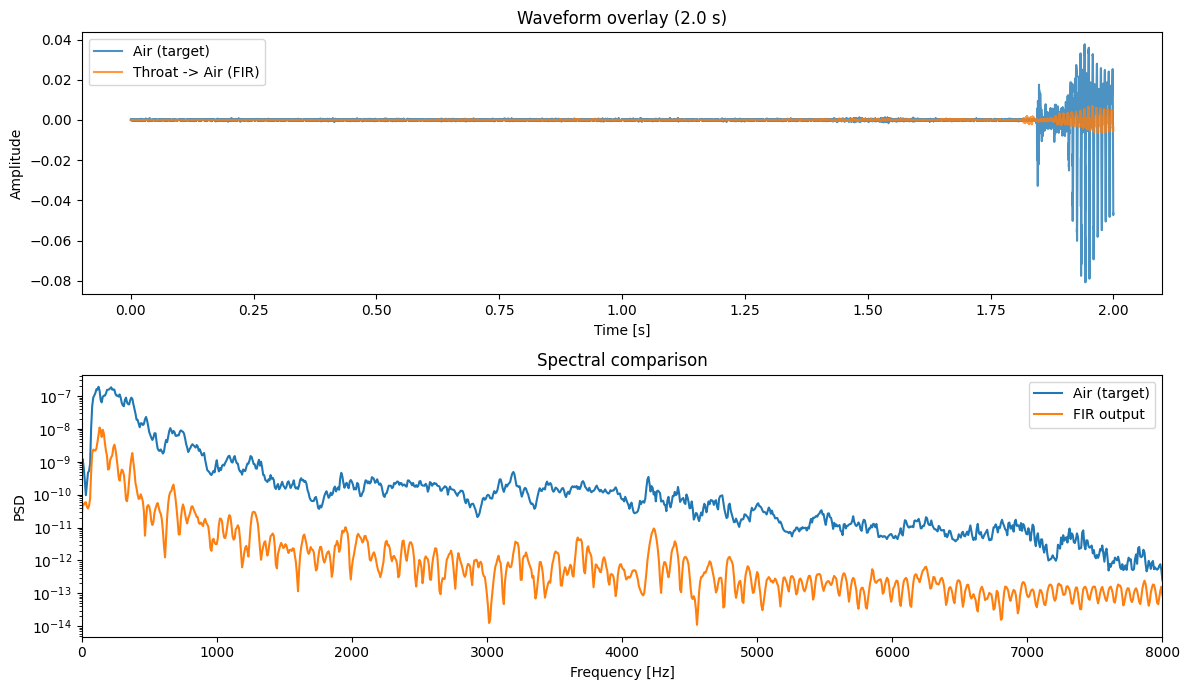

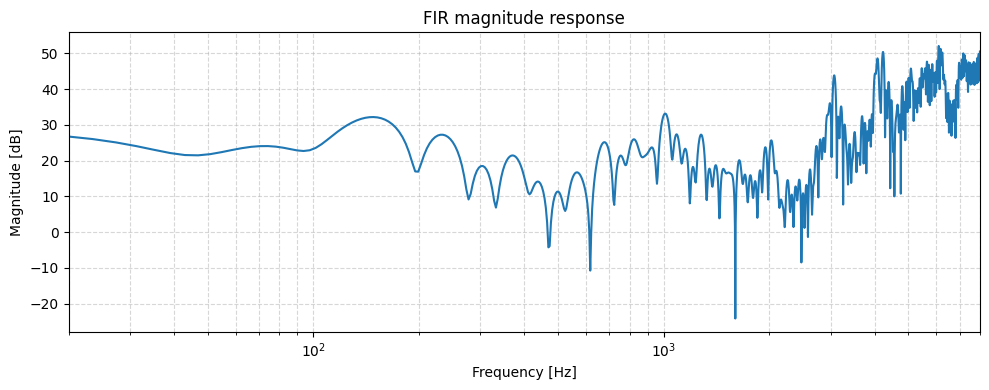

Saved:
 - test/air_target.wav
 - test/throat_original_raw.wav
 - test/throat_original_aligned.wav
 - test/throat_filtered_fir.wav


In [19]:
# Design FIR/IIR to map throat -> air, apply, compare, and save WAVs
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from math import gcd
from scipy import signal
from scipy.linalg import toeplitz

# Save raw inputs for listening first
try:
    sf.write('test/throat_original_raw.wav', (data_throat/np.max(np.abs(data_throat)+1e-12))*0.99, sr_throat)
    sf.write('test/air_target.wav', (data_air/np.max(np.abs(data_air)+1e-12))*0.99, sr_air)
except Exception:
    pass

# Work on copies
x = np.asarray(data_throat, dtype=float).copy()  # throat (input)
y = np.asarray(data_air, dtype=float).copy()     # air (target)
fs_x, fs_y = int(sr_throat), int(sr_air)

# 1) Resample throat to air sample rate if needed
if fs_x != fs_y:
    g = gcd(fs_y, fs_x)
    up, down = fs_y // g, fs_x // g
    x = signal.resample_poly(x, up, down)
    fs = fs_y
else:
    fs = fs_x

# Make same length
N = min(len(x), len(y))
x = x[:N]
y = y[:N]

# DC removal
x = x - np.mean(x)
y = y - np.mean(y)

# 2) Time-align via cross-correlation (bulk delay)
corr = signal.correlate(y, x, mode='full')
lags = np.arange(-len(x)+1, len(y))
lag = lags[np.argmax(corr)]  # y ~ x shifted by -lag
shift = -int(lag)

def shift_with_zeros(sig, shift_samples):
    sig = np.asarray(sig)
    L = len(sig)
    if shift_samples > 0:
        # delay: move right
        out = np.concatenate([np.zeros(shift_samples), sig[:-shift_samples]])
    elif shift_samples < 0:
        k = -shift_samples
        # advance: move left
        out = np.concatenate([sig[k:], np.zeros(k)])
    else:
        out = sig.copy()
    return out[:L]

x_al = shift_with_zeros(x, shift)

# Optional overall gain alignment (least-squares scalar)
num = np.dot(x_al, y)
den = np.dot(x_al, x_al) + 1e-12
gain0 = num / den
x_al *= gain0

# 3) FIR Wiener filter design (time-domain, length L)
L_fir = 256  # adjust if needed (e.g., 512 for more detail)
# autocorr and crosscorr (non-negative lags)
rxx_full = signal.correlate(x_al, x_al, mode='full')
rxy_full = signal.correlate(y, x_al, mode='full')
mid = len(x_al) - 1
rxx = rxx_full[mid:mid+L_fir]
rxy = rxy_full[mid:mid+L_fir]

R = toeplitz(rxx)
# Tikhonov regularization for stability
reg = 1e-6 * np.max(np.diag(R))
R_reg = R + reg * np.eye(L_fir)
h_fir = np.linalg.solve(R_reg, rxy)

# Apply FIR
y_hat_fir = signal.lfilter(h_fir, [1.0], x_al)

# 4) Optional IIR via Prony to approximate FIR impulse response
b_iir = a_iir = None
y_hat_iir = None
try:
    M = 10  # numerator order
    N_den = 10  # denominator order
    b_iir, a_iir = signal.prony(h_fir, M, N_den)
    # Stability guard: if any poles outside unit circle, skip IIR
    poles = np.roots(a_iir)
    if np.any(np.abs(poles) >= 1):
        b_iir = a_iir = None
    else:
        y_hat_iir = signal.lfilter(b_iir, a_iir, x_al)
except Exception:
    b_iir = a_iir = None

# 5) Evaluation metrics

def eval_fit(y_true, y_pred):
    if y_pred is None:
        return None
    y_true = y_true[:len(y_pred)]
    y_pred = y_pred[:len(y_true)]
    err = y_true - y_pred
    mse = float(np.mean(err**2))
    var = float(np.var(y_true) + 1e-12)
    snr_db = 10 * np.log10(var / (mse + 1e-12))
    corr = float(np.corrcoef(y_true, y_pred)[0, 1])
    return dict(mse=mse, snr_db=snr_db, corr=corr)

metrics_fir = eval_fit(y, y_hat_fir)
metrics_iir = eval_fit(y, y_hat_iir)

print("FIR fit:", metrics_fir)
print("IIR fit:", metrics_iir if metrics_iir is not None else "skipped or unstable")

# 6) Plots: time overlay (short window), spectra, and FIR response
sec = 2.0
n_win = int(sec * fs)
idx0 = 0
idx1 = min(len(y), idx0 + n_win)

t = np.arange(idx0, idx1) / fs
plt.figure(figsize=(12, 7))
plt.subplot(2,1,1)
plt.plot(t, y[idx0:idx1], label='Air (target)', alpha=0.8)
plt.plot(t, y_hat_fir[idx0:idx1], label='Throat -> Air (FIR)', alpha=0.8)
if y_hat_iir is not None:
    plt.plot(t, y_hat_iir[idx0:idx1], label='Throat -> Air (IIR)', alpha=0.8)
plt.title('Waveform overlay ({} s)'.format(sec))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2,1,2)
# magnitude spectra (Welch)
f_fir, Pyy_fir = signal.welch(y_hat_fir, fs=fs, nperseg=2048)
f_air, Pyy_air = signal.welch(y, fs=fs, nperseg=2048)
plt.semilogy(f_air, Pyy_air, label='Air (target)')
plt.semilogy(f_fir, Pyy_fir, label='FIR output')
if y_hat_iir is not None:
    f_iir, Pyy_iir = signal.welch(y_hat_iir, fs=fs, nperseg=2048)
    plt.semilogy(f_iir, Pyy_iir, label='IIR output')
plt.xlim(0, 8000)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('Spectral comparison')
plt.legend()
plt.tight_layout()
plt.show()

# FIR frequency response
w, H = signal.freqz(h_fir, [1.0], worN=2048, fs=fs)
plt.figure(figsize=(10,4))
plt.semilogx(w, 20*np.log10(np.maximum(np.abs(H), 1e-9)))
plt.title('FIR magnitude response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.xlim(20, fs/2)
plt.tight_layout()
plt.show()

# 7) Save WAVs: throat aligned+resampled and filtered outputs
out_dir = 'test'
orig_path = f"{out_dir}/throat_original_aligned.wav"
fir_path = f"{out_dir}/throat_filtered_fir.wav"
iir_path = f"{out_dir}/throat_filtered_iir.wav"

# Normalize to prevent clipping during listening

def norm_audio(a):
    a = np.asarray(a, dtype=float)
    mx = np.max(np.abs(a))
    return a if mx < 1e-9 else 0.99 * a / mx

sf.write(orig_path, norm_audio(x_al), fs)
sf.write(fir_path, norm_audio(y_hat_fir), fs)
if y_hat_iir is not None:
    sf.write(iir_path, norm_audio(y_hat_iir), fs)

print("Saved:")
print(" - test/air_target.wav")
print(" - test/throat_original_raw.wav")
print(" -", orig_path)
print(" -", fir_path)
if y_hat_iir is not None:
    print(" -", iir_path)


In [33]:
results['test/air_target.wav'].text

'テニスにもあるけど、四大大会って何？濃いコーヒーより薄いコーヒーの方が好きです。外交官には様々な特権が与えられている。'

In [37]:
# Transcribe WAVs with OpenAI Whisper (or GPT transcription) and compare transcripts
import os, re, difflib, json
from dataclasses import dataclass
from typing import Dict, List, Tuple

try:
    from openai import OpenAI
    _openai_available = True
except Exception:
    _openai_available = False

AUDIO_FILES = [
    'test/air_target.wav',
    'test/throat_original_raw.wav',
    'test/throat_original_aligned.wav',
    'test/throat_filtered_fir.wav'
]
REFERENCE_FILE = 'test/air_target.wav'  # use air microphone as reference transcript
DEFAULT_MODEL_PRIMARY = 'gpt-4o-mini-transcribe'  # adjust if unavailable
FALLBACK_MODEL = 'whisper-1'

@dataclass
class TranscriptionResult:
    file: str
    model: str
    text: str
    error: str | None = None

# Text normalization for fair WER
_punct_re = re.compile(r"[\.,!?;:\-\"'()\[\]{}<>=/\\]")
_whitespace_re = re.compile(r"\s+")

def normalize_text(t: str) -> str:
    t = t.lower()
    t = _punct_re.sub("", t)
    t = _whitespace_re.sub(" ", t).strip()
    return t

def wer(ref: str, hyp: str) -> float:
    r = ref.split()
    h = hyp.split()
    R, H = len(r), len(h)
    # DP matrix
    dp = [[0]*(H+1) for _ in range(R+1)]
    for i in range(R+1):
        dp[i][0] = i
    for j in range(H+1):
        dp[0][j] = j
    for i in range(1, R+1):
        for j in range(1, H+1):
            cost = 0 if r[i-1] == h[j-1] else 1
            dp[i][j] = min(
                dp[i-1][j] + 1,      # deletion
                dp[i][j-1] + 1,      # insertion
                dp[i-1][j-1] + cost  # substitution
            )
    return dp[R][H] / max(1, R)

def unified_diff(a: str, b: str, from_label: str, to_label: str, n: int = 3) -> str:
    a_lines = a.split()
    b_lines = b.split()
    diff = difflib.unified_diff(a_lines, b_lines, lineterm="", fromfile=from_label, tofile=to_label, n=n)
    return "\n".join(diff)

client = None
if _openai_available and os.getenv('OPENAI_API_KEY'):
    try:
        client = OpenAI()
    except Exception as e:
        print(f"Failed to init OpenAI client: {e}")
else:
    if not _openai_available:
        print("openai package not available; install or ensure dependency.")
    else:
        print("OPENAI_API_KEY not set; export it to enable transcription.")

results: Dict[str, TranscriptionResult] = {}

if client is not None:
    for path in AUDIO_FILES:
        if not os.path.exists(path):
            results[path] = TranscriptionResult(file=path, model=DEFAULT_MODEL_PRIMARY, text="", error="missing file")
            continue
        # Try primary model then fallback
        audio_file = open(path, 'rb')
        used_model = None
        text_out = ""
        err = None
        for mdl in [DEFAULT_MODEL_PRIMARY, FALLBACK_MODEL]:
            try:
                used_model = mdl
                # New-style Audio transcription endpoint
                resp = client.audio.transcriptions.create(
                    model=mdl,
                    file=audio_file,
                )
                # Some SDK versions return .text, others may nest data
                text_out = getattr(resp, 'text', None) or (resp.get('text') if isinstance(resp, dict) else "")
                if not text_out:
                    text_out = str(resp)
                break
            except Exception as e:
                err = str(e)
                audio_file.seek(0)  # rewind for next attempt
                continue
        audio_file.close()
        results[path] = TranscriptionResult(file=path, model=used_model or DEFAULT_MODEL_PRIMARY, text=text_out, error=err if text_out == "" else None)
else:
    # Placeholder dummy transcripts (so later code still runs) — user can re-run after setting key
    for path in AUDIO_FILES:
        placeholder = f"(no API key) placeholder transcript for {os.path.basename(path)}"
        results[path] = TranscriptionResult(file=path, model='N/A', text=placeholder, error='no_api_key')

# Build normalized transcripts
norm_texts: Dict[str, str] = {p: normalize_text(r.text) for p, r in results.items()}

# Reference transcript
ref_norm = norm_texts.get(REFERENCE_FILE, "")
if not ref_norm:
    print("Reference transcript empty; WER metrics may be meaningless.")

report_rows: List[Tuple[str, str, float]] = []
for path in AUDIO_FILES:
    hyp = norm_texts.get(path, "")
    w = wer(ref_norm, hyp) if ref_norm and hyp else None
    report_rows.append((path, results[path].model, w))

print("Transcription Summary (WER vs air_target reference):")
print("File, Model, WER")
for file, model, w in report_rows:
    print(f"{file}, {model}, {w if w is not None else 'NA'}")

# Show pairwise diffs relative to reference (first 1-2 diffs for brevity)
for path in AUDIO_FILES:
    if path == REFERENCE_FILE:
        continue
    diff_str = unified_diff(ref_norm, norm_texts[path], 'air_target', os.path.basename(path), n=5)
    print("\nDiff vs", path, "(word-level approximation):")
    print(diff_str[:4000] if diff_str else "(No differences after normalization)")

# Structured JSON summary (could be saved if needed)
summary = {
    'model_versions': {p: r.model for p, r in results.items()},
    'text': {p: r.text for p, r in results.items()},
    'errors': {p: r.error for p, r in results.items() if r.error},
    'wer': {p: w for p, _, w in report_rows},
    'reference': REFERENCE_FILE,
}
print("\nJSON Summary:")
print(json.dumps(summary, indent=2, ensure_ascii=False))

# Optional: save summary to file
try:
    with open('test/transcription_comparison_summary.json', 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)
    print("Saved test/transcription_comparison_summary.json")
except Exception as e:
    print("Could not write summary file:", e)

print("Done. If placeholder transcripts were used, set OPENAI_API_KEY and re-run this cell.")

Transcription Summary (WER vs air_target reference):
File, Model, WER
test/air_target.wav, gpt-4o-mini-transcribe, 0.0
test/throat_original_raw.wav, gpt-4o-mini-transcribe, 1.0
test/throat_original_aligned.wav, gpt-4o-mini-transcribe, 1.0
test/throat_filtered_fir.wav, gpt-4o-mini-transcribe, 1.0

Diff vs test/throat_original_raw.wav (word-level approximation):
--- air_target
+++ throat_original_raw.wav
@@ -1 +1 @@
-テニスにもあるけど、四大大会って何濃いコーヒーより薄いコーヒーの方が好きです。外交官には様々な特権が与えられている。
+テニスにもあるけど、四大大会って何テイスティングより薄いコーヒーの方が好きです。ガイコウバには様々な特典が与えられている。

Diff vs test/throat_original_aligned.wav (word-level approximation):
--- air_target
+++ throat_original_aligned.wav
@@ -1 +1 @@
-テニスにもあるけど、四大大会って何濃いコーヒーより薄いコーヒーの方が好きです。外交官には様々な特権が与えられている。
+テニスにもあるけど、四大大会って何濃いコーヒーより薄いコーヒーの方が好きです。ライトバーには様々な特典が与えられている。

Diff vs test/throat_filtered_fir.wav (word-level approximation):
--- air_target
+++ throat_filtered_fir.wav
@@ -1 +1 @@
-テニスにもあるけど、四大大会って何濃いコーヒーより薄いコーヒーの方が好きです。外交官には様々な特権が与えられている。
+テニスにもあるけど、四大大会って何？濃いコーヒーより

In [39]:
# Apply designed FIR filter to another audio file
import numpy as np
import soundfile as sf
from scipy import signal
from math import gcd

# Load the target audio file
input_file = "recordings/20250812115046_GHW_USB_AUDIO.wav"
output_file = "recordings/20250812115046_GHW_USB_AUDIO_FIR.wav"

# Load audio data
data_input, sr_input = sf.read(input_file)

# Convert to mono if stereo
if data_input.ndim > 1:
    data_input = np.mean(data_input, axis=1)

# Work on copy
x_new = np.asarray(data_input, dtype=float).copy()

# Resample to match the filter's design sampling rate if needed
if sr_input != fs:
    g = gcd(fs, sr_input)
    up, down = fs // g, sr_input // g
    x_new = signal.resample_poly(x_new, up, down)
    fs_new = fs
else:
    fs_new = sr_input

# DC removal
x_new = x_new - np.mean(x_new)

# Apply the designed FIR filter
y_filtered = signal.lfilter(h_fir, [1.0], x_new)

# Normalize to prevent clipping
def norm_audio(a):
    a = np.asarray(a, dtype=float)
    mx = np.max(np.abs(a))
    return a if mx < 1e-9 else 0.99 * a / mx

# Save filtered audio
sf.write(output_file, norm_audio(y_filtered), fs_new)

print(f"Applied FIR filter to {input_file}")
print(f"Saved filtered audio to {output_file}")
print(f"Filter length: {len(h_fir)} taps")
print(f"Processing sample rate: {fs_new} Hz")

Applied FIR filter to recordings/20250812115046_GHW_USB_AUDIO.wav
Saved filtered audio to recordings/20250812115046_GHW_USB_AUDIO_FIR.wav
Filter length: 256 taps
Processing sample rate: 16000 Hz
